In [1]:
# set the working directory to be the root of the package
# so that the imports work below
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import models.data_util
import seaborn
import random

In [3]:
data_file = "../data/med.pkl"  # set this accordingly

db = pd.read_pickle(data_file)

# Load the lat/long for each company
x = db[['lat', 'long']].to_numpy()
y = db['isfailed'].to_numpy().reshape((-1,))

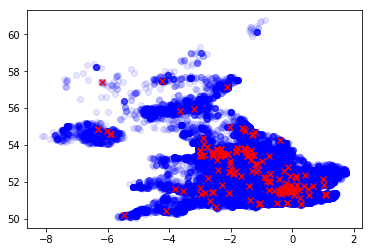

In [4]:
# plot the lat/long of all companies in the dataset:

failedcomps = np.nonzero(y == 1)
notfailedcomps = np.nonzero(y == 0)

# transpose is needed to make the UK look upright!
plt.scatter(x[notfailedcomps].T[1], x[notfailedcomps].T[0],
            marker='o', alpha=0.1, color='blue')
plt.scatter(x[failedcomps].T[1], x[failedcomps].T[0],
            marker='x', alpha=1.0, color='red')
plt.show()

In [5]:
# file path of a cleaned data file (so we can see the difference
# to lat/long)

cleaned_data_file = "../data/clean.pkl"  # set this accordingly

clean_data = pd.read_pickle(cleaned_data_file)

In [6]:
clean_db_failed = clean_data[clean_data['isfailed'] == 1]
clean_db_notfailed = clean_data[clean_data['isfailed'] == 0]

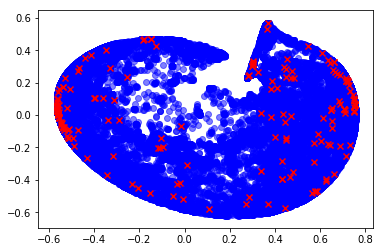

In [7]:
# plot the lat/long of the companies in the cleaned dataset, which has had
# PCA applied to the positions:

plt.scatter(clean_db_notfailed['pos1'].to_numpy(), clean_db_notfailed['pos2'].to_numpy(),
            marker='o', alpha=0.5, color='blue')
plt.scatter(clean_db_failed['pos1'].to_numpy(), clean_db_failed['pos2'].to_numpy(),
            marker='x', alpha=1.0, color='red')
plt.show()

In [8]:
# Now let's examine the following accounting fields:
# Field2267, Field2816, Field972, Field477, Field2823
# These are pesky because they don't have a corresponding hasFN field
# and some of the fields contain strings, too.
from models.feature_util import (accounting_field_nums,
                                 bad_accounting_field_nums)

In [9]:
# As we can see from this, most of these fields are pretty hard to train on:
for n in bad_accounting_field_nums:
    fieldName = 'Field' + str(n)
    fieldNotNone = db[db[fieldName].notna()][fieldName]
    series = fieldNotNone.sample(frac=0.1).to_numpy()
    print(fieldName, ':', series.shape)
    print(series)

Field2267 : (1926,)
['' '' '' ... '' '' '']
Field2816 : (86,)
['Turnover comprises revenue recognised by the company in respect of services supplied, exclusive of Value Added Tax.\tIn respect of long-term contracts and contracts for on-going services, turnover represents the value of work done in the year, including estimates of amounts not invoiced. Turnover in respect of long-term contracts and contracts for on-going services is recognised by reference to the stage of completion.'
 'Turnover represents net invoiced sales of goods, excluding value added tax. '
 'Turnover represents invoiced commission for insurance intermediary services supplied.'
 'Turnover represents amounts chargeable, net of value added tax, in respect of the sale of goods and services to customers.'
 'The turnover shown in the profit and loss account represents amounts invoiced during the year, exclusive of Value Added Tax.'
 'Turnover comprises revenue recognised by the company in respect of goods supplied, excl

Field1014 : 72719 values


e:\programs folder\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
e:\programs folder\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


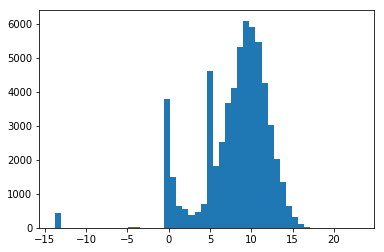

Field1129 : 89028 values


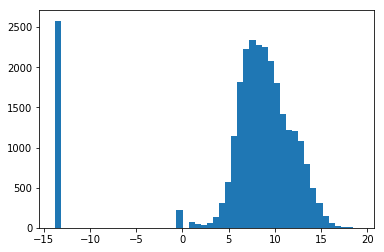

Field1522 : 99903 values


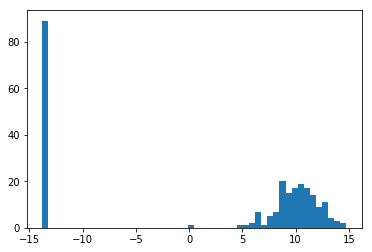

Field1631 : 99024 values


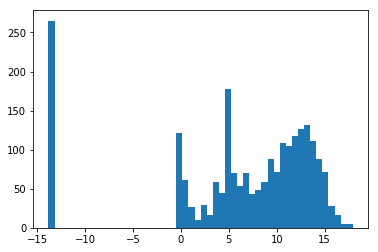

Field17 : 99728 values


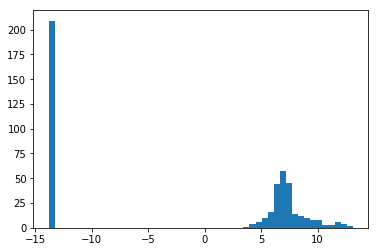

Field1865 : 79235 values


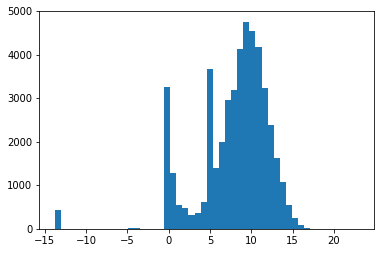

Field1871 : 97611 values


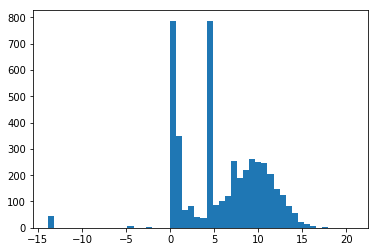

Field1885 : 80059 values


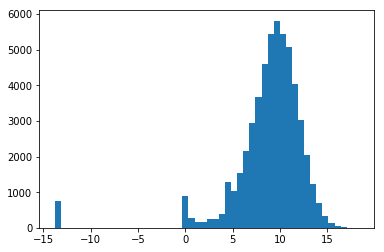

Field1977 : 99980 values


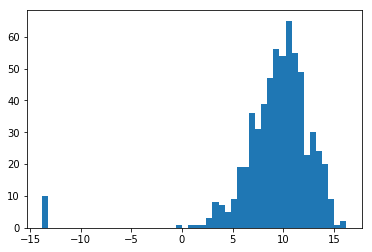

Field2298 : 99950 values


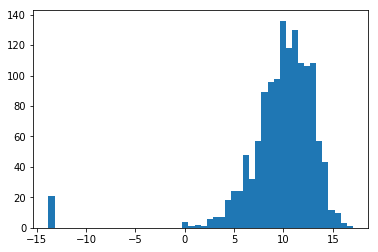

Field2304 : 99990 values


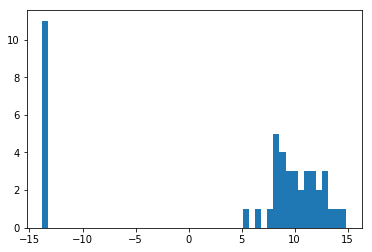

Field2316 : 93687 values


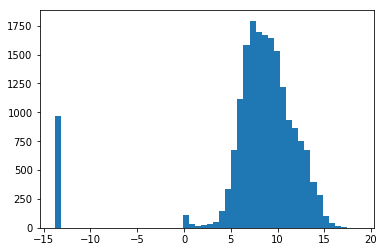

Field2447 : 99938 values


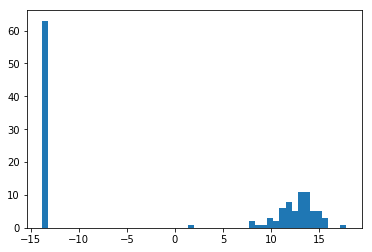

Field2483 : 99989 values


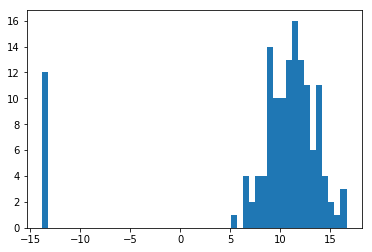

Field2497 : 97638 values


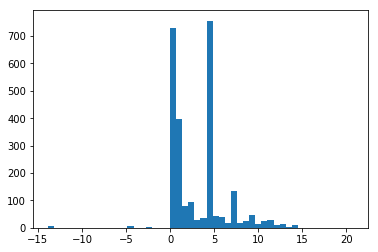

Field2502 : 97625 values


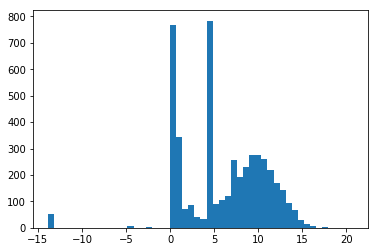

Field2815 : 99996 values


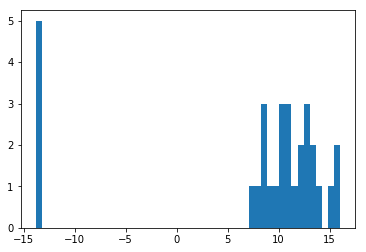

Field282 : 99934 values


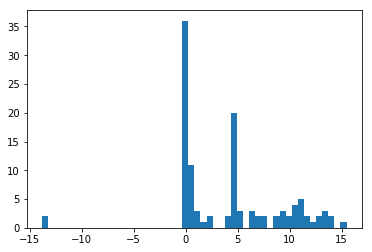

Field306 : 90088 values


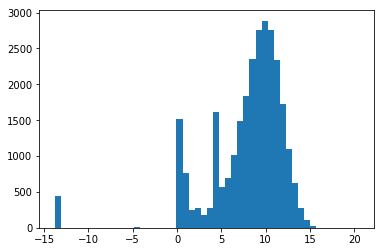

Field448 : 99973 values


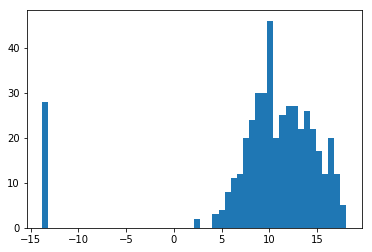

Field465 : 87457 values


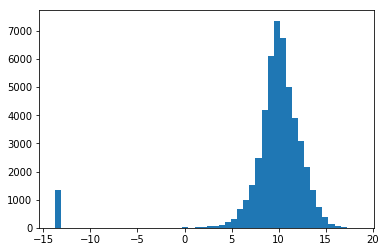

Field474 : 99837 values


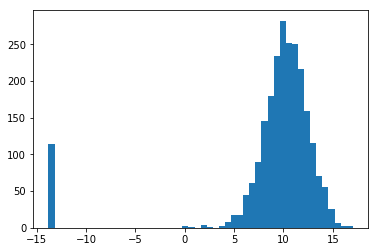

Field487 : 99733 values


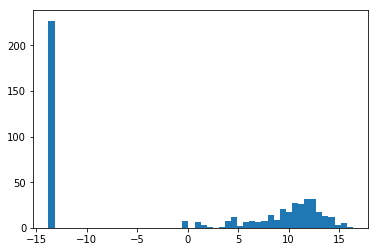

Field489 : 87427 values


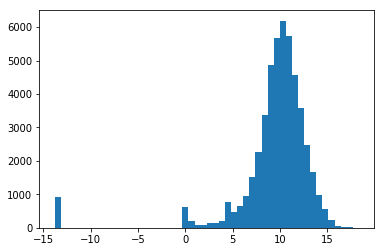

Field541 : 94347 values


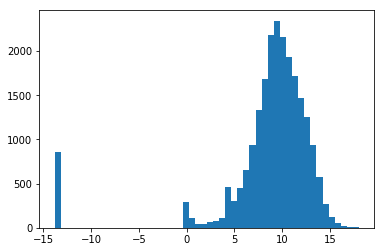

Field69 : 99878 values


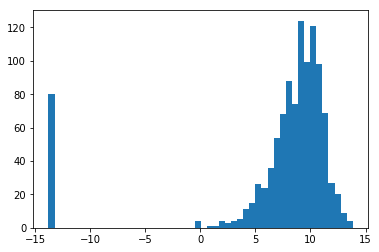

Field70 : 99833 values


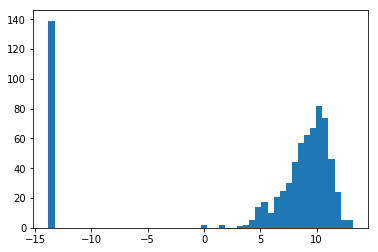

In [10]:
# Now examine the "good" accounting fields:
acc_field_names = ['Field' + str(n) for n in accounting_field_nums]
for field_name in acc_field_names:
    col_data = db[field_name].to_numpy()
    print(field_name, ':', len(np.unique(col_data)), 'values')
    col_data = np.log(col_data + 1.0e-6)  # plot on log scale
    plt.hist(col_data, bins=50)
    plt.show()

In [11]:
print("Columns in cleaned dataset:")
for col in clean_data.columns:
    # get num unique values of this col:
    numunique = -1
    
    try:
        numunique = len(np.unique(clean_data[col]))
    except TypeError:
        pass  # can occur when comparing None values
    
    print(col, ':', numunique, "unique value(s)")

Columns in cleaned dataset:
Field1014 : 72719 unique value(s)
Field1129 : 89028 unique value(s)
Field1522 : 99903 unique value(s)
Field1631 : 99024 unique value(s)
Field17 : 99728 unique value(s)
Field1865 : 79235 unique value(s)
Field1871 : 97611 unique value(s)
Field1885 : 80059 unique value(s)
Field1977 : 99980 unique value(s)
Field2298 : 99950 unique value(s)
Field2304 : 99990 unique value(s)
Field2316 : 93687 unique value(s)
Field2447 : 99938 unique value(s)
Field2483 : 99989 unique value(s)
Field2497 : 97638 unique value(s)
Field2502 : 97625 unique value(s)
Field2506 : 99944 unique value(s)
Field2616 : 99934 unique value(s)
Field2619 : 99983 unique value(s)
Field2705 : 82604 unique value(s)
Field2815 : 99996 unique value(s)
Field282 : 99934 unique value(s)
Field306 : 90088 unique value(s)
Field448 : 99973 unique value(s)
Field465 : 87457 unique value(s)
Field474 : 99837 unique value(s)
Field487 : 99733 unique value(s)
Field489 : 87427 unique value(s)
Field541 : 94347 unique value